# Assigment II

Samer Abufoul \
Manor Nir

### Libraries loading


In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import Image, display
from PIL import ImageOps

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


import tensorflow as tf
import keras 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from keras.backend import clear_session
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras.callbacks import ModelCheckpoint


### Data loading

In [ ]:
tf.random.set_seed(75)

In [ ]:
y_train = np.load('drive/MyDrive/assigment 2 data mldl/Y_train.npy')

In [ ]:
x_train = np.load('drive/MyDrive/assigment 2 data mldl/X_train.npy')

In [ ]:
y_test = np.load('drive/MyDrive/assigment 2 data mldl/Y_test.npy')

In [ ]:
x_test = np.load('drive/MyDrive/assigment 2 data mldl/X_test.npy')

In [ ]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of x_train is: (3200, 180, 180, 3)
Shape of y_train is: (3200,)
Shape of x_test is: (800, 180, 180, 3)
Shape of y_test is: (800,)


normalizing test data, train and validation data will be noramlized in the model.

In [ ]:
x_test = x_test / 255.0 

plotting random samples

<Figure size 432x288 with 0 Axes>

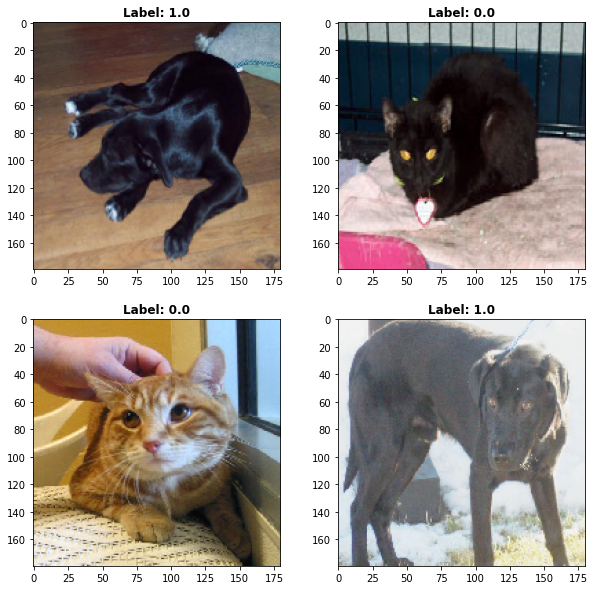

In [ ]:
def plot_random_samples(x, y):
  plt.figure()

  f, axarr = plt.subplots(2, 2, figsize=(10,10)) 
  rands = np.random.randint(x.shape[0], size=4)
  axarr[0, 0].imshow((x[rands[0], :, :,:]).astype(np.uint8))
  axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow((x[rands[1], :, :,:]).astype(np.uint8))
  axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')

  axarr[0, 1].imshow((x[rands[2], :, :,:]).astype(np.uint8))
  axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')

  axarr[1, 1].imshow((x[rands[3], :, :,:]).astype(np.uint8))
  axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')

  plt.show()

plot_random_samples(x_train, y_train)

### Splitting train data

spliiting train data into train and validation with preserving the same proportions of each class.

In [ ]:
x_train, x_validation, y_train, y_validation = \
        train_test_split(x_train, y_train, train_size=0.75, stratify=y_train, random_state=42)
x_train.shape, x_validation.shape

((2400, 180, 180, 3), (800, 180, 180, 3))

### Data augmentation

Due to having few training samples we're using data augmentation. also we normalized the data in order to have better preformances.

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rescale=1./255,
        vertical_flip=True,
        fill_mode='nearest')

In [ ]:
datagen.fit(x_train)

## Basic convolutional neural network model


In [ ]:
smodel = Sequential()
smodel.add(Conv2D(32, (3, 3), input_shape= (180, 180, 3))) #1st 2d convolutional layer
smodel.add(Activation('relu'))
smodel.add(MaxPooling2D(pool_size=(2, 2)))

smodel.add(Conv2D(64, (3, 3))) #2nd 2d convolutional layer
smodel.add(Activation('relu'))
smodel.add(MaxPooling2D(pool_size=(2, 2)))

smodel.add(Conv2D(128, (3, 3))) #3rd 2d convolutional layer
smodel.add(Activation('relu'))
smodel.add(MaxPooling2D(pool_size=(2, 2)))

smodel.add(Conv2D(256, (3, 3))) #4th 2d convolutional layer
smodel.add(Activation('relu'))
smodel.add(MaxPooling2D(pool_size=(2, 2)))

smodel.add(Flatten())  
smodel.add(Dense(256)) # Fully connected layer
smodel.add(Activation('relu'))
smodel.add(Dropout(0.5))
smodel.add(Dense(2, activation="softmax"))




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 87, 87, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                    

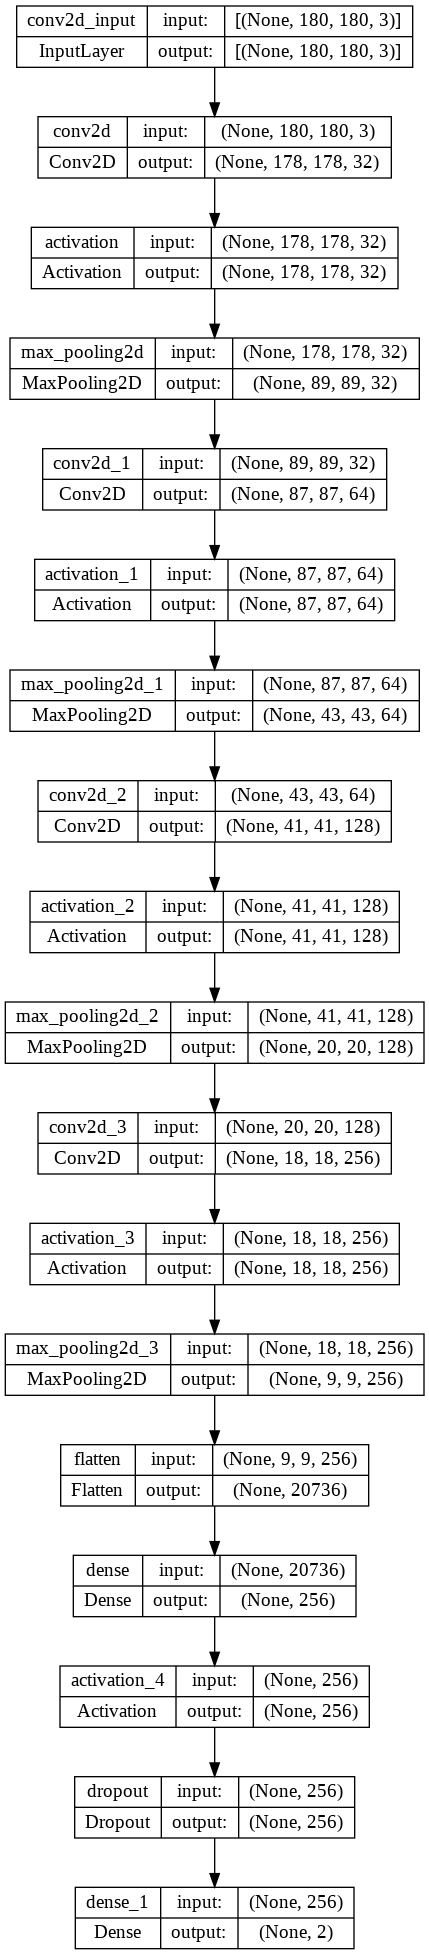

In [ ]:
from keras.utils.vis_utils import plot_model
print(smodel.summary())
plot_model(smodel, show_shapes=True, show_layer_names=True)

we used spare categorical crossentropy function because in the last layer the activation function is soft max', we compiled the model with adam and rmsprop the latter one had the best preformance.

In [ ]:
smodel.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop', # best optimizer 
              metrics=['accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("simple_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
]

In [ ]:
epochs = 32
if not os.path.exists("simple_model.h5"):
  smodel.fit(datagen.flow(x_train, y_train, batch_size=32),
          validation_data=datagen.flow(x_validation, y_validation,
          batch_size=8),
          steps_per_epoch=len(x_train) / 32, epochs=epochs,callbacks = callbacks)

Epoch 1/32
75/75 [==============================] - 31s 295ms/step - loss: 0.8851 - accuracy: 0.5125 - val_loss: 0.6908 - val_accuracy: 0.5288
Epoch 2/32
75/75 [==============================] - 22s 294ms/step - loss: 0.7136 - accuracy: 0.5325 - val_loss: 0.6859 - val_accuracy: 0.5550
Epoch 3/32
75/75 [==============================] - 22s 290ms/step - loss: 0.7069 - accuracy: 0.5675 - val_loss: 0.6952 - val_accuracy: 0.5150
Epoch 4/32
75/75 [==============================] - 22s 291ms/step - loss: 0.6895 - accuracy: 0.5650 - val_loss: 0.6920 - val_accuracy: 0.5225
Epoch 5/32
75/75 [==============================] - 22s 289ms/step - loss: 0.6836 - accuracy: 0.5967 - val_loss: 0.8096 - val_accuracy: 0.5437
Epoch 6/32
75/75 [==============================] - 22s 290ms/step - loss: 0.6750 - accuracy: 0.6008 - val_loss: 0.6307 - val_accuracy: 0.6037
Epoch 7/32
75/75 [==============================] - 22s 291ms/step - loss: 0.6620 - accuracy: 0.6037 - val_loss: 0.6283 - val_accuracy: 0.6275

In [ ]:
if os.path.exists("simple_model.h5"):
    smodel = tf.keras.models.load_model('/content/simple_model.h5')

In [ ]:
acc_val = smodel.evaluate(x_validation, y_validation, verbose=0)
print('train loss, train acc:', acc_val)
 

train loss, train acc: [44.90061569213867, 0.6237499713897705]


In [ ]:
acc_test = smodel.evaluate(x_test, y_test, verbose=0)
print('test loss, test acc:', acc_test)

test loss, test acc: [0.5073862075805664, 0.7599999904632568]


In [ ]:
y_pred = smodel.predict(x_test)
y_pred

25/25 [==============================] - 1s 16ms/step


array([[0.59289443, 0.40710562],
       [0.18320084, 0.81679916],
       [0.45166695, 0.54833305],
       ...,
       [0.29138225, 0.7086177 ],
       [0.66900575, 0.3309943 ],
       [0.2919346 , 0.7080654 ]], dtype=float32)

In [ ]:
y_pred_basic = y_pred.argmax(axis =1 )
y_pred_basic

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,

In [ ]:
y_test_int = y_test.astype('int')

In [ ]:
from sklearn.metrics import accuracy_score
acc_basic = accuracy_score(y_test_int, y_pred_basic)

In [ ]:
print('Accuracy: ',acc_basic)

Accuracy:  0.76


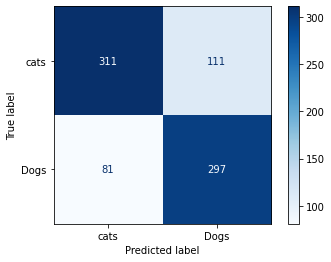

In [ ]:
cm = confusion_matrix(y_test_int, y_pred_basic)
labels = ['cats','Dogs']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Modified convolutional neural network model

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), input_shape= (180, 180, 3))) #1st 2d convolutional layer
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (3, 3))) #2nd 2d convolutional layer
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3))) #3rd 2d convolutional layer
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, (3, 3))) #4th 2d convolutional layer
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten())  
model_2.add(Dense(256)) # 1st fully connected layer
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
#model_2.add(Flatten())  
model_2.add(Dense(128)) # 2nd fully connected layer
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(2,activation="softmax"))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 activation_23 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 activation_24 (Activation)  (None, 87, 87, 32)        0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                 

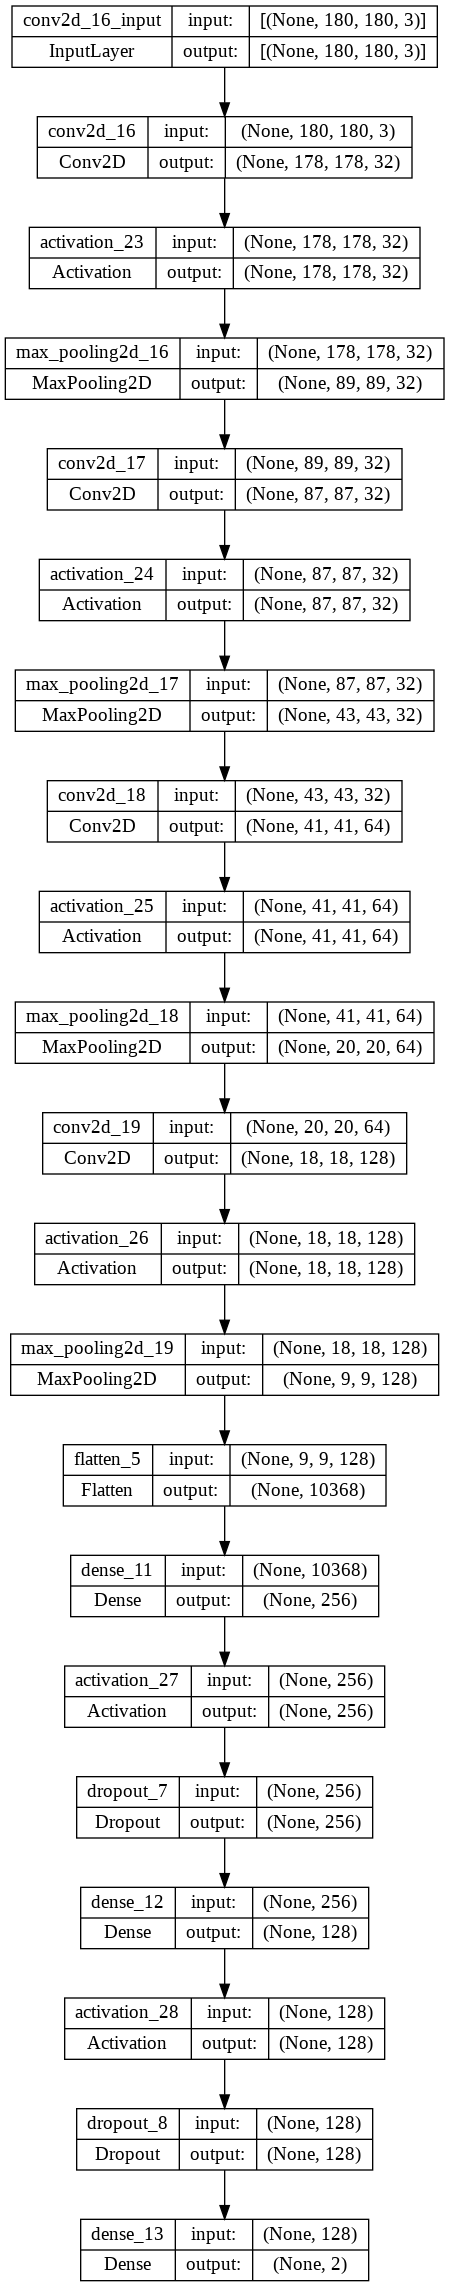

In [ ]:
print(model_2.summary())
plot_model(model_2, show_shapes=True, show_layer_names=True)

In [ ]:
model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
callbacks_2 = [
    tf.keras.callbacks.ModelCheckpoint("model_2.h5", save_best_only=True, monitor='val_accuracy', mode='max')
]

In [ ]:
epochs = 32
if not os.path.exists("model_2.h5"):
  model_2.fit(datagen.flow(x_train, y_train, batch_size=32),
          validation_data=datagen.flow(x_validation, y_validation,
          batch_size=8), 
          steps_per_epoch=len(x_train) / 32, epochs=epochs,callbacks = callbacks_2)

Epoch 1/32
75/75 [==============================] - 23s 301ms/step - loss: 0.6982 - accuracy: 0.5067 - val_loss: 0.6927 - val_accuracy: 0.5063
Epoch 2/32
75/75 [==============================] - 22s 297ms/step - loss: 0.6947 - accuracy: 0.5067 - val_loss: 0.6909 - val_accuracy: 0.5063
Epoch 3/32
75/75 [==============================] - 22s 297ms/step - loss: 0.6938 - accuracy: 0.5312 - val_loss: 0.6873 - val_accuracy: 0.5487
Epoch 4/32
75/75 [==============================] - 22s 295ms/step - loss: 0.6879 - accuracy: 0.5704 - val_loss: 0.6727 - val_accuracy: 0.5713
Epoch 5/32
75/75 [==============================] - 22s 292ms/step - loss: 0.6802 - accuracy: 0.5813 - val_loss: 0.6752 - val_accuracy: 0.5575
Epoch 6/32
75/75 [==============================] - 22s 294ms/step - loss: 0.6803 - accuracy: 0.5958 - val_loss: 0.6635 - val_accuracy: 0.5962
Epoch 7/32
75/75 [==============================] - 22s 294ms/step - loss: 0.6802 - accuracy: 0.6037 - val_loss: 0.6788 - val_accuracy: 0.5625

In [ ]:
if os.path.exists("model_2.h5"):
    model_2 = tf.keras.models.load_model('/content/model_2.h5')

In [ ]:
acc_2_val = model_2.evaluate(x_validation, y_validation, verbose=0)
print('train loss, train acc:', acc_2_val)

train loss, train acc: [48.02739334106445, 0.6299999952316284]


In [ ]:
acc_2_test = model_2.evaluate(x_test, y_test, verbose=0)
print('test loss, test acc:', acc_2_test)

test loss, test acc: [0.5265733599662781, 0.7825000286102295]


In [ ]:
y_pred = model_2.predict(x_test)
y_pred_modified = y_pred.argmax(axis =1 )
acc_modified = accuracy_score(y_test_int, y_pred_modified)

25/25 [==============================] - 0s 14ms/step


In [ ]:
print('Accuracy: ',acc_modified)

Accuracy:  0.7825


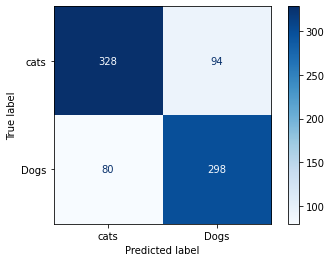

In [ ]:
cm_modified = confusion_matrix(y_test_int, y_pred_modified)

disp_modified = ConfusionMatrixDisplay(confusion_matrix=cm_modified, display_labels=labels)

disp_modified.plot(cmap=plt.cm.Blues)
plt.show()

## Modified pre trained model from keras

we chose InceptionV3 model as a base model we added one hiddden layer with relu activation function.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model


In [ ]:
pre_model = InceptionV3(weights='imagenet', include_top=False, input_shape= (180, 180, 3)) # create the base pre-trained model

pre_model.trainable = False # Freeze the pretrained weights
x = pre_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x) # adding fully-connected layer
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_3 = Model(inputs=pre_model.input, outputs=predictions)


In [ ]:
print(model_3.summary())
plot_model(model_3, show_shapes=True, show_layer_names=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_302 (Conv2D)            (None, 89, 89, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 89, 89, 32)  96          ['conv2d_302[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
model_3.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop', # best optimizer 
              metrics=['accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_3.h5", save_best_only=True, monitor='val_accuracy', mode='max')
]

In [ ]:
epochs_3 = 32
if not os.path.exists("model_3.h5"):
  model_3.fit(datagen.flow(x_train, y_train, batch_size=32),
          validation_data=datagen.flow(x_validation, y_validation,
          batch_size=8), 
          steps_per_epoch=len(x_train) / 32, epochs=epochs_3,callbacks = callbacks_2)

Epoch 1/32
75/75 [==============================] - 31s 350ms/step - loss: 27.4593 - accuracy: 0.7646 - val_loss: 1.1816 - val_accuracy: 0.8637
Epoch 2/32
75/75 [==============================] - 23s 308ms/step - loss: 1.2427 - accuracy: 0.8058 - val_loss: 0.3222 - val_accuracy: 0.8612
Epoch 3/32
75/75 [==============================] - 24s 327ms/step - loss: 0.9918 - accuracy: 0.8062 - val_loss: 0.2861 - val_accuracy: 0.8900
Epoch 4/32
75/75 [==============================] - 23s 309ms/step - loss: 0.7178 - accuracy: 0.8346 - val_loss: 0.5447 - val_accuracy: 0.8612
Epoch 5/32
75/75 [==============================] - 23s 306ms/step - loss: 0.5172 - accuracy: 0.8629 - val_loss: 0.3929 - val_accuracy: 0.8675
Epoch 6/32
75/75 [==============================] - 24s 323ms/step - loss: 0.5652 - accuracy: 0.8442 - val_loss: 0.2458 - val_accuracy: 0.8963
Epoch 7/32
75/75 [==============================] - 23s 307ms/step - loss: 0.4813 - accuracy: 0.8575 - val_loss: 0.2604 - val_accuracy: 0.891

In [ ]:
if os.path.exists("model_3.h5"):
    model_3 = tf.keras.models.load_model('/content/model_3.h5')

In [ ]:
acc_3_val = model_3.evaluate(x_validation, y_validation, verbose=0)
print('train loss, train acc:', acc_3_val)

train loss, train acc: [25.585712432861328, 0.5387499928474426]


In [ ]:
y_pred = model_3.predict(x_test)
y_pred_3 = y_pred.argmax(axis =1 )
acc_modified_3 = accuracy_score(y_test_int, y_pred_3)

25/25 [==============================] - 3s 52ms/step


In [ ]:
print('Accuracy: ',acc_modified_3)

Accuracy:  0.975


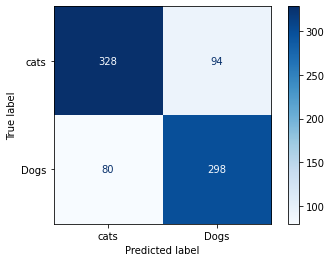

In [ ]:
cm_modified_2 = confusion_matrix(y_test_int, y_pred_3)

disp_modified_2 = ConfusionMatrixDisplay(confusion_matrix=cm_modified_2, display_labels=labels)

disp_modified.plot(cmap=plt.cm.Blues)
plt.show()

## Results Table

In [ ]:
import pandas as pd

results = {'model': ['Basic CNN','My Model', 'InceptionV3'],
           'Test score (Accuracy)': [acc_basic, acc_modified, acc_modified_3],
           'Train score (Accuracy)': [acc_val[1], acc_2_val[1], acc_3_val[1]],
           'Number of trainable parameters': [5697602, 2790114, 55360290],
           'Number of layers': [6, 7, 'pre trained model + 1 fully connected + output'],
           'Regularization methods': ['Dropout','Dropout','Dropout, Batch normalization'],
           'Number of epochs': [epochs, epochs, epochs_3],
           'Loss function': ['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
           'Optimizer': ['rmsprop', 'rmsprop', 'rmsprop']
           }

df = pd.DataFrame(results)
df

model  Test score (Accuracy)  Train score (Accuracy)  \
0    Basic CNN                 0.7600                 0.62375   
1     My Model                 0.7825                 0.63000   
2  InceptionV3                 0.9750                 0.53875   

   Number of trainable parameters  \
0                         5697602   
1                         2790114   
2                        55360290   

                                 Number of layers  \
0                                               6   
1                                               7   
2  pre trained model + 1 fully connected + output   

         Regularization methods  Number of epochs  \
0                       Dropout                32   
1                       Dropout                32   
2  Dropout, Batch normalization                32   

                     Loss function Optimizer  
0  sparse_categorical_crossentropy   rmsprop  
1  sparse_categorical_crossentropy   rmsprop  
2  sparse_categorical_crossentropy   rmsprop

In [ ]:
from google.colab import files
df.to_csv('exercise2.csv')
files.download('exercise2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>